# Building and deploying ASOS fashion recommender
> Building a fashion recommender using tensorflow and deploying using tensorflow serving

- toc: true
- badges: true
- comments: true
- categories: [Fashion, Tensorflow, Tensorflow Serving, Workshop, Vidoe Tutorial]
- image:

## Loading data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

In [ ]:
train = pd.read_parquet("https://raw.githubusercontent.com/ASOS/dsf2020/main/dsf_asos_train_with_alphanumeric_dummy_ids.parquet")
valid = pd.read_parquet("https://raw.githubusercontent.com/ASOS/dsf2020/main/dsf_asos_valid_with_alphanumeric_dummy_ids.parquet")
dummy_users = pd.read_csv("https://raw.githubusercontent.com/ASOS/dsf2020/main/dsf_asos_dummy_users_with_alphanumeric_dummy_ids.csv", header=None).values.flatten().astype(str)
products = pd.read_csv("https://raw.githubusercontent.com/ASOS/dsf2020/main/dsf_asos_productIds.csv", header=None).values.flatten().astype(int)

## Beginners guide

The embedding layer gives a list of random numbers for each user and each product.

In [ ]:
# we can think of this like we are representing 5 users with 8 features
embed1 = tf.keras.layers.Embedding(5, 8)

# these features values are initialized randomly
embed1.get_weights()

# what is the embedding for user 2
embed1(1)

Scores can be found using the dot product.

In [ ]:
dummy_users

array(['pmfkU4BNZhmtLgJQwJ7x', 'UDRRwOlzlWVbu7H8YCCi',
       'QHGAef0TI6dhn0wTogvW', ..., 'lcORJ5hemOZc1iGo9z7k',
       '5CqDquDAszqJp27P7AL8', 'SSPNYxJMfuKhoe1dg24m'], dtype='<U20')

In [ ]:
dummy_user_embedding = tf.keras.layers.Embedding(len(dummy_users), 6)

In [ ]:
# embedding for user 11
dummy_user_embedding(10)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([ 0.01467596, -0.02954445,  0.03404785,  0.01231953,  0.04366143,
       -0.0044396 ], dtype=float32)>

In [ ]:
products

array([ 8650774,  9306139,  9961521, ..., 12058614, 12058615, 11927550])

In [ ]:
product_embedding = tf.keras.layers.Embedding(len(products), 6)

In [ ]:
# embedding for item 100
product_embedding(99)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([ 0.02277244,  0.02625698, -0.01999602, -0.03833932,  0.0345167 ,
       -0.01270068], dtype=float32)>

In [ ]:
# what is the dot product of user 11 and item 100
tf.tensordot(dummy_user_embedding(10), product_embedding(99), axes=[[0],[0]])

<tf.Tensor: shape=(), dtype=float32, numpy=-3.1250045e-05>

We can score multiple products at the same time, which is what we need to create a ranking.

In [ ]:
# let's select any 4 products which we want to rank for a given user
example_product = tf.constant([1, 99, 150, 1893])

In [ ]:
# we can now lookup the embeddings for these products
product_embedding(example_product)

<tf.Tensor: shape=(4, 6), dtype=float32, numpy=
array([[ 0.04060421, -0.02407475,  0.04868412, -0.04409076, -0.04359574,
         0.01877945],
       [ 0.02277244,  0.02625698, -0.01999602, -0.03833932,  0.0345167 ,
        -0.01270068],
       [-0.00228758, -0.03117471, -0.03875785, -0.02510407,  0.02122536,
         0.02693504],
       [-0.02317454, -0.03613551,  0.01375883, -0.03972936, -0.04336563,
         0.03636159]], dtype=float32)>

In [ ]:
# we can now rank the products for user 11
tf.tensordot(dummy_user_embedding(10), product_embedding(example_product), axes=[[0],[1]])

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([ 4.3476743e-04, -3.1250045e-05,  6.5724162e-05, -1.3483301e-03],
      dtype=float32)>

And we can score multiple users for multiple products which we will need to do if we are to train quickly.

In [ ]:
# let's select any 5 users
example_dummy_users = tf.constant([1, 15, 64, 143, 845])

In [ ]:
# we can now lookup the embeddings for these users
dummy_user_embedding(example_dummy_users)

<tf.Tensor: shape=(5, 6), dtype=float32, numpy=
array([[-0.00500759, -0.01592503, -0.04531288,  0.03634879, -0.04445822,
         0.02233071],
       [ 0.04351348, -0.01561077, -0.03777659,  0.04860062, -0.04637348,
         0.0177078 ],
       [ 0.02677048,  0.02643926, -0.03807139,  0.03903792,  0.03431937,
         0.04447547],
       [-0.02116373,  0.01084019,  0.03190598, -0.0420518 ,  0.03488394,
        -0.01088031],
       [-0.03455943,  0.01424483, -0.02845301,  0.01910288, -0.02961202,
        -0.03374088]], dtype=float32)>

In [ ]:
# we can now rank the products for all 5 users in one go
tf.tensordot(dummy_user_embedding(example_dummy_users), product_embedding(example_product), axes=[[1],[1]])

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[-1.2710541e-03, -2.8378544e-03,  1.0094778e-03,  1.3638806e-03],
       [ 5.1492616e-04, -2.3524766e-03,  1.2385333e-04, -2.4003588e-04],
       [-3.7851618e-03,  1.1881565e-03,  1.5364687e-03, -3.5216413e-03],
       [ 5.6198158e-04,  2.1191915e-03, -2.3099157e-05,  3.0003395e-04],
       [-3.3163456e-03, -1.1699977e-03, -1.2791414e-03, -8.0699811e-04]],
      dtype=float32)>

But we need to map product ids to embedding ids.

In [ ]:
products

array([ 8650774,  9306139,  9961521, ..., 12058614, 12058615, 11927550])

In [ ]:
product_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(tf.constant(products, dtype=tf.int32), 
                                        range(len(products))), -1)

In [ ]:
# We can now ask the product table for a id of a product
product_table.lookup(tf.constant([9961521]))

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>

## Model

Let's put those two things together

In [ ]:
class SimpleRecommender(tf.keras.Model):
    def __init__(self, dummy_users, products, len_embed):
        super(SimpleRecommender, self).__init__()
        self.products = tf.constant(products, dtype=tf.int32)
        self.dummy_users = tf.constant(dummy_users, dtype=tf.string)
        self.dummy_user_table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(self.dummy_users, range(len(dummy_users))), -1)
        self.product_table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(self.products, range(len(products))), -1)
        
        self.user_embedding = tf.keras.layers.Embedding(len(dummy_users), len_embed)
        self.product_embedding = tf.keras.layers.Embedding(len(products), len_embed)

        self.dot = tf.keras.layers.Dot(axes=-1)
        
    # task idiom: "personalized ranking"
    # business use case: "recommended for you, mainly served on the home page"
    def call(self, inputs):
        users = inputs[0]
        products = inputs[1]

        user_embedding_index = self.dummy_user_table.lookup(users)
        product_embedding_index = self.product_table.lookup(products)

        user_embedding_values = self.user_embedding(user_embedding_index)
        product_embedding_values = self.product_embedding(product_embedding_index)

        return tf.squeeze(self.dot([user_embedding_values, product_embedding_values]))

    # task idiom: "item to item similarity"
    # business use case: "similar items you might like, mainly served on the product page"
    @tf.function
    def call_item_item(self, product):
        product_x = self.product_table.lookup(product)
        pe = tf.expand_dims(self.product_embedding(product_x), 0)
        
        all_pe = tf.expand_dims(self.product_embedding.embeddings, 0)#note this only works if the layer has been built!
        scores = tf.reshape(self.dot([pe, all_pe]), [-1])
        
        top_scores, top_indices = tf.math.top_k(scores, k=100)
        top_ids = tf.gather(self.products, top_indices)
        return top_ids, top_scores

In [ ]:
dummy_users

array(['pmfkU4BNZhmtLgJQwJ7x', 'UDRRwOlzlWVbu7H8YCCi',
       'QHGAef0TI6dhn0wTogvW', ..., 'lcORJ5hemOZc1iGo9z7k',
       '5CqDquDAszqJp27P7AL8', 'SSPNYxJMfuKhoe1dg24m'], dtype='<U20')

In [ ]:
products

array([ 8650774,  9306139,  9961521, ..., 12058614, 12058615, 11927550])

In [ ]:
# let's sanity check the model
srl = SimpleRecommender(dummy_users, products, 15)

# let's check for 2 users and 3 products
srl([tf.constant([['pmfkU4BNZhmtLgJQwJ7x'], ['UDRRwOlzlWVbu7H8YCCi']]),
     tf.constant([[8650774,  9306139,  9961521], [12058614, 12058615, 11927550]])
     ])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 0.00225708, -0.00308297, -0.00388317],
       [ 0.00299652,  0.00012062, -0.00198898]], dtype=float32)>

## Dataset

First create a tf.data.Dataset from the user purchase pairs.

In [ ]:
train.head()

,dummyUserId,productId
0,b'PIXcm7Ru5KmntCy0yA1K',10524048
1,b'd0RILFB1hUzNSINMY4Ow',9137713
2,b'Ebax7lyhnKRm4xeRlWW2',5808602
3,b'vtigDw2h2vxKt0sJpEeU',10548272
4,b'r4GfiEaUGxziyjX0PyU6',10988173


In [ ]:
dummy_user_tensor = tf.constant(train[["dummyUserId"]].values, dtype=tf.string)
product_tensor = tf.constant(train[["productId"]].values, dtype=tf.int32)

dataset = tf.data.Dataset.from_tensor_slices((dummy_user_tensor, product_tensor))
for x, y in dataset:
    print(x)
    print(y)
    break

tf.Tensor([b'PIXcm7Ru5KmntCy0yA1K'], shape=(1,), dtype=string)
tf.Tensor([10524048], shape=(1,), dtype=int32)


For each purchase let's sample a number of products that the user did not purchase. Then the model can score each of the products and we will know we are doing a good job if the product with the highest score is the product that the user actually purchased.

We can do this using dataset.map

In [ ]:
class Mapper():
    
    def __init__(self, possible_products, num_negative_products):
        self.num_possible_products = len(possible_products)
        self.possible_products_tensor = tf.constant(possible_products, dtype=tf.int32)
        
        self.num_negative_products = num_negative_products
        self.y = tf.one_hot(0, num_negative_products+1)
    
    def __call__(self, user, product):
        random_negative_indices = tf.random.uniform((self.num_negative_products, ), minval=0, maxval=self.num_possible_products, dtype=tf.int32)
        negatives = tf.gather(self.possible_products_tensor, random_negative_indices)
        candidates = tf.concat([product, negatives], axis=0)
        return (user, candidates), self.y

In [ ]:
# let's sanity check the mapper fucntion
dataset = tf.data.Dataset.from_tensor_slices((dummy_user_tensor, product_tensor)).map(Mapper(products, 10))
for (u,c), y in dataset:
  print(u)
  print(c)
  print(y)
  break

tf.Tensor([b'PIXcm7Ru5KmntCy0yA1K'], shape=(1,), dtype=string)
tf.Tensor(
[10524048 12291895 10154254 10814078  9362779 10055301  8296010 10818624
 12340298  7286392 12942312], shape=(11,), dtype=int32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(11,), dtype=float32)


Note: we are selecting negative samples from all products, which might include products that user in fact purchased, and this is going to add a factor of error but we are intentionally ignoring for now because this error factor is insignificant for the time being. Before productionizing, we will indeed take care of this.

Let's bring the steps together to define a function which creates a dataset 

In [ ]:
# let's wrap the dataset operations and check for a single user
def get_dataset(df, products, num_negative_products):
    dummy_user_tensor = tf.constant(df[["dummyUserId"]].values, dtype=tf.string)
    product_tensor = tf.constant(df[["productId"]].values, dtype=tf.int32)
    dataset = tf.data.Dataset.from_tensor_slices((dummy_user_tensor, product_tensor))
    dataset = dataset.map(Mapper(products, num_negative_products))
    return dataset

In [ ]:
for (u, c), y in get_dataset(train, products, 3):
  print(u)
  print(c)
  print(y)
  break

tf.Tensor([b'PIXcm7Ru5KmntCy0yA1K'], shape=(1,), dtype=string)
tf.Tensor([10524048 12221823 10731514 10077541], shape=(4,), dtype=int32)
tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


In [ ]:
# let's now make it for a whole batch of users at a time that we will pass to the model
def get_dataset(df, products, num_negative_products):
    dummy_user_tensor = tf.constant(df[["dummyUserId"]].values, dtype=tf.string)
    product_tensor = tf.constant(df[["productId"]].values, dtype=tf.int32)
    dataset = tf.data.Dataset.from_tensor_slices((dummy_user_tensor, product_tensor))
    dataset = dataset.map(Mapper(products, num_negative_products))
    dataset = dataset.batch(1024)
    return dataset

In [ ]:
for (u, c), y in get_dataset(train, products, 3):
  print(u)
  print(c)
  print(y)
  break

tf.Tensor(
[[b'PIXcm7Ru5KmntCy0yA1K']
 [b'd0RILFB1hUzNSINMY4Ow']
 [b'Ebax7lyhnKRm4xeRlWW2']
 ...
 [b'xuX9n8PHfSR0AP3UZ8ar']
 [b'iNnxsPFfOa9884fMjVPJ']
 [b'aD8Mn12im8lFPzXAY41P']], shape=(1024, 1), dtype=string)
tf.Tensor(
[[10524048 12973419 10294391 12109690]
 [ 9137713 11636228 11391810 10108923]
 [ 5808602 11927418 12242832 12511570]
 ...
 [11541336 10524604  8910126 10769218]
 [ 7779232  8567541 13216243 11731157]
 [ 4941259  9732363  9346943 13073630]], shape=(1024, 4), dtype=int32)
tf.Tensor(
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]], shape=(1024, 4), dtype=float32)


## Training

We need to compile a model, set the loss and create an evaluation metric. Then we need to train the model.

In [ ]:
# we are using categorical cross entropy, which means we are formulating our task as a classification problem now
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# 100 works well for this use case but we can make this as a hyperparameter to find a more optimal lr
optimizer = tf.keras.optimizers.SGD(learning_rate=100.)

metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
#hide-output
model = SimpleRecommender(dummy_users, products, 15)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.fit(get_dataset(train, products, num_negative_products=100),
          validation_data=get_dataset(valid, products, 100),
          epochs=5)

Epoch 1/5
162/162 [==============================] - 12s 66ms/step - loss: 4.6151 - categorical_accuracy: 0.0134 - val_loss: 4.6151 - val_categorical_accuracy: 0.0176
Epoch 2/5
162/162 [==============================] - 10s 64ms/step - loss: 4.6119 - categorical_accuracy: 0.0827 - val_loss: 4.6146 - val_categorical_accuracy: 0.0464
Epoch 3/5
162/162 [==============================] - 10s 64ms/step - loss: 4.5974 - categorical_accuracy: 0.1902 - val_loss: 4.6031 - val_categorical_accuracy: 0.0789
Epoch 4/5
162/162 [==============================] - 10s 64ms/step - loss: 4.5117 - categorical_accuracy: 0.2366 - val_loss: 4.5326 - val_categorical_accuracy: 0.1024
Epoch 5/5
162/162 [==============================] - 10s 65ms/step - loss: 4.2767 - categorical_accuracy: 0.2375 - val_loss: 4.3773 - val_categorical_accuracy: 0.1112


Let's do a manual check on whether the model is any good.

In [ ]:
products

array([ 8650774,  9306139,  9961521, ..., 12058614, 12058615, 11927550])

In [ ]:
test_product = np.random.choice(products)
test_product

11086208

In [ ]:
print("Go to https://www.asos.com/prd/{} to see the product description.".format(test_product))

Go to https://www.asos.com/prd/11086208 to see the product description.


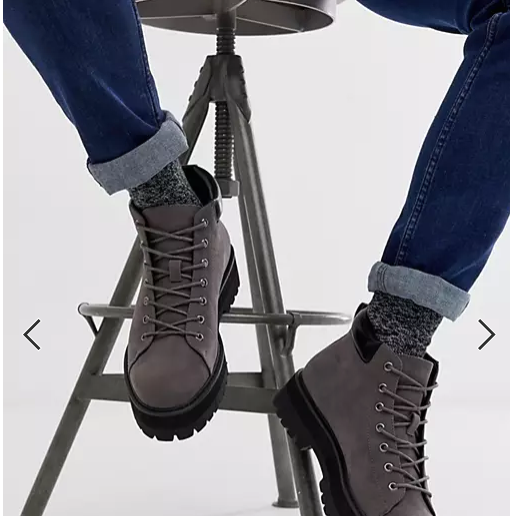

In [ ]:
similar_recs = model.call_item_item(tf.constant(test_product, dtype=tf.int32))
print("Recs for item {}: {}".format(test_product, similar_recs))

Recs for item 11086208: (<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([ 6848491,  9099410,  5026837,  9775640,  9775636,  8745098,
        7777858,  8603141,  9586825, 10856809, 10635879, 11771631,
        8718389, 11999269, 11389407,  9099144,  8745086, 10563215,
       11654329,  7103401,  9775638,  8203362, 11060961,  8745089,
       11003606,  7098445, 10903185, 10266253, 10718009, 10366062,
        9873330, 10402703, 10635862, 10309924,  9690295, 10308540,
       10208979,  9655345,  8904051, 10606801, 10716895,  7098451,
        9968967,  8324668, 10563207, 10353428,  9528191,  8782509,
       11450313, 11101484,  8612741, 10904276, 10912244, 10281377,
        7917036, 10911669, 12159121, 13112623, 11801850,  6430186,
        9276051, 10353402, 12356865, 10269381,  8811498, 10183844,
       12367051,  8469705,  4275772, 10309920, 11344538, 10309914,
       10354955, 11450738, 12466734, 10636194, 10817653, 11462637,
        4903066,  9221799, 11344130, 11152568, 11113272,  

In [ ]:
print("The user also likes to purchase {}, and {}. Go to https://www.asos.com/prd/{}, https://www.asos.com/prd/{} to see the recommended product description."\
      .format(similar_recs[0][0].numpy(), similar_recs[0][1].numpy(),
              similar_recs[0][0].numpy(), similar_recs[0][1].numpy()))

The user also likes to purchase 6848491, and 9099410. Go to https://www.asos.com/prd/6848491, https://www.asos.com/prd/9099410 to see the recommended product description.


It seems people like to buy this t-shirt and sunglasses along with the shoes:

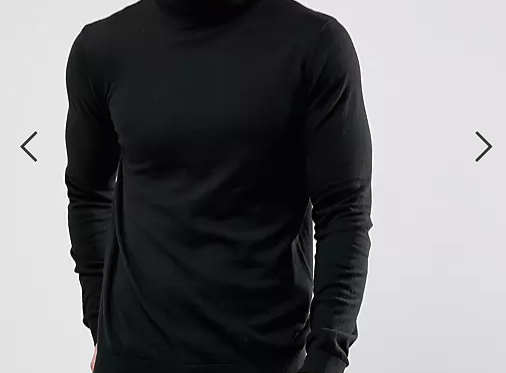

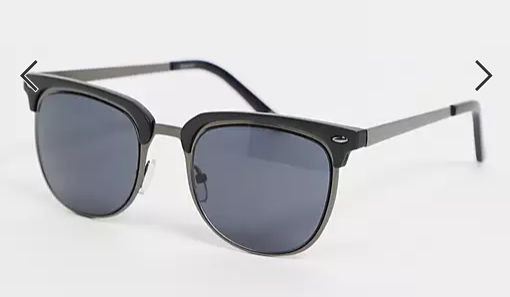

Insight: Instead of learning user embeddings, we can say - "user embedding is the product sum of product embeddings the user purchased in the past". Then we can take the dot product of this user embedding with the product embeddings (which we can enhance by adding image and text features) to calculate the similarity.

## Save the model

In [ ]:
model_path = "models/recommender/1"

In [ ]:
inpute_signature = tf.TensorSpec(shape=(), dtype=tf.int32)

In [ ]:
signatures = { 'call_item_item': model.call_item_item.get_concrete_function(inpute_signature)}

In [ ]:
tf.saved_model.save(model, model_path, signatures=signatures)

In [ ]:
from zipfile import ZipFile
import os
# create a ZipFile object
with ZipFile('models.zip', 'w') as zipObj:
   # Iterate over all the files in directory
    for folderName, subfolders, filenames in os.walk("models"):
        for filename in filenames:
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath)

In [ ]:
#hide-output
# let's examine the saved model by using the command line utility saved_model_cli
# to look at the MetaGraphDefs (the models) and SignatureDefs (the methods you
# can call) in our SavedModel

!saved_model_cli show --dir {model_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['call_item_item']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['product'] tensor_info:
        dtype: DT_INT32
        shape: ()
        name: call_item_item_product:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_0'] tensor_info:
        dtype: DT_INT32
        shape: (100)
        name: StatefulPartitionedCall_2:0
    outputs['output_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (100)
        name: StatefulPartitionedCall_2:1
  Method name is: tensorflow/serving/predict
W0622 06:52:59.496681 

## Load model

In [ ]:
imported_model = tf.saved_model.load(model_path)
list(imported_model.signatures.keys())

['call_item_item']

In [ ]:
products

array([ 8650774,  9306139,  9961521, ..., 12058614, 12058615, 11927550])

In [ ]:
result_tensor = imported_model.signatures['call_item_item'](tf.constant([8650774]))

In [ ]:
#hide-output
from IPython.core.display import HTML

def path_to_image_html(path):
  return '<img src="https://images.asos-media.com/products/ugg-classic-mini-boots-in-black-suede/'+str(path)+'-2" width="60" >'

result_df = pd.DataFrame(result_tensor['output_0'].numpy(), columns=['ProductUrl']).head()
HTML(result_df.to_html(escape=False, formatters=dict(ProductUrl=path_to_image_html)))

,ProductUrl
0,
1,
2,
3,
4,


## Serve

### On colab

In [ ]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  15654      0 --:--:-- --:--:-- --:--:-- 15654
OK
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-

In [ ]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 326 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.5.1 [326 MB]
Fetched 326 MB in 5s (62.2 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.5.1_all.deb ...
Unpacking tensorflow-model-server (2.5.1) ...
Setting up tensorflow-model-server (2.5.1) ...


This is where we start running TensorFlow Serving and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [ ]:
os.environ["MODEL_PATH"] = "/content/models/recommender"

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8508 \
  --model_name=recommender \
  --model_base_path="${MODEL_PATH}" >server.log 2>&1

Starting job # 7 in a separate thread.


In [ ]:
!tail server.log

2021-06-22 07:19:18.055773: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /content/models/recommender/1
2021-06-22 07:19:18.215098: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 244315 microseconds.
2021-06-22 07:19:18.218029: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /content/models/recommender/1/assets.extra/tf_serving_warmup_requests
2021-06-22 07:19:18.218211: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: recommender version: 1}
2021-06-22 07:19:18.218865: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-06-22 07:19:18.218936: I tensorflow_serving/model_servers/server.cc:367] Profiler service is enabled
2021-06-22 07:19:18.219401: I tensorflow_serving/model_servers/server.cc:393

### Running tensorflow serving in local Docker container

In [ ]:
# # The recommended way of running Tensorflow serving is with Docker image.

# # Environment setup
# - docker engine installed and running to run a serve
#     General installation instructions are on the [Docker site](https://docs.docker.com/get-docker/), but some quick links here:
#     [Docker for macOS](https://docs.docker.com/docker-for-mac/install/)
#     [Docker for Windows](https://docs.docker.com/docker-for-windows/install/)
# - http client installed to run a client 
#     [Curl for mac](https://curl.haxx.se/dlwiz/?type=source&os=Mac+OS+X)  
  

# cd {recommender-model-folder}
# docker pull tensorflow/serving

# # Windows
# docker run -d -p 8501:8501 -v "$PWD/:/models/recommender" -e MODEL_NAME=recommender tensorflow/serving

# # Mac
# docker run -d -p 8501:8501 --mount type=bind,source=${PWD}/,target='/models/recommender' -e MODEL_NAME=recommender tensorflow/serving

# # Windows
# $rec_request = @"
# {
# "signature_name" : "call_item_item",
# "inputs" : {
# "item": [123123]
# }
# }
# "@
# $rec_response = Invoke-RestMethod -Uri "http://localhost:8501/v1/models/recommender:predict" -Method Post -Body $rec_request -ContentType "application/json"
# $rec_response | convertto-json

# # Mac
# curl --header "Content-Type: application/json" --request POST --data '{"signature_name":"call_item_item","inputs": {"item": [123123] } }' http://localhost:8501/v1/models/recommender:predict

# # Windows
# $output = Invoke-RestMethod http://localhost:8501/v1/models/recommender/metadata
# $output | convertto-json

# # Mac
# curl http://localhost:8501/v1/models/recommender/metadata

## Inference

In [ ]:
import json
test_sample = json.dumps({"signature_name": "call_item_item", "inputs": {"product":[8650774]}})
test_sample

'{"signature_name": "call_item_item", "inputs": {"product": [8650774]}}'

In [ ]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8508/v1/models/recommender:predict', data=test_sample, headers=headers)
# json_response = requests.post('http://localhost:8508/v1/models/recommender/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['outputs']

In [ ]:
predictions['output_0'][0:10]

[7329586,
 10958640,
 9364605,
 10811849,
 11890074,
 10102320,
 12241228,
 12115410,
 11409811,
 11179817]